In [1]:
import os
from math import pi

# Use 8 CPU devices
# os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit, pmap
from jax import random

# jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, MN_POTENTIAL, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

from odisseo.option_classes import DIFFRAX_BACKEND, DOPRI5, TSIT5, SEMIIMPLICITEULER, LEAPFROGMIDPOINT, REVERSIBLEHEUN

In [2]:
from jax.scipy.integrate import trapezoid
from galpy.potential import MiyamotoNagaiPotential


def mass_enclosed_MN(R, z):
    """
    Compute the mass of the Myamoto-Nagai potential at a given radius R.

    """
    a = params.MN_params.a * code_units.code_length.to(u.kpc)
    b = params.MN_params.b * code_units.code_length.to(u.kpc)
    M = params.MN_params.M * code_units.code_mass.to( u.Msun)

    # Compute the mass using the Myamoto-Nagai formula
    mp = MiyamotoNagaiPotential(amp = M, a=a, b=b,) 

    return mp.mass(R, z) * u.Msun.to(code_units.code_mass)
    
@jit
def mass_enclosed_NFW(R):
    """
    Compute the mass of the NFW potential at a given radius R.

    ref: wikipedia
    """
    c = params.NFW_params.c
    Mvir = params.NFW_params.Mvir
    r_s = params.NFW_params.r_s
    rho_0 = (Mvir / (4*jnp.pi * r_s**3)) * (jnp.log(1+c) - c/(1+c))**-1

    return 4*jnp.pi*rho_0*r_s**3 * (jnp.log(1 + R/r_s) - R/(r_s + R))

    

In [11]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)


# Define the 
config = SimulationConfig(N_particles = 10_000, 
                          return_snapshots = True, 
                          num_snapshots = 50, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  ), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          integrator = DIFFRAX_BACKEND,
                          diffrax_solver = REVERSIBLEHEUN,
                          softening = (0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (1000 * u.Myr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                           MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (15.0 * u.kpc).to(code_units.code_length).value,
                                               c = 8.0),                           
                          G=G, ) 

key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#put the Plummer sphere in a ciruclar orbit around the NFW halo
ra = 200*u.kpc.to(code_units.code_length)
e = 0.9
rp = (1-e)/(1+e) * ra

pos_com = sample_position_on_sphere(key=key,
                                r_p = rp,
                                num_samples=1,)
z = pos_com[0, 2]
inclination = jnp.pi/2 - jnp.acos(z/rp)

mass1 = mass_enclosed_MN(rp, z) + mass_enclosed_NFW(rp)
mass2 = params.Plummer_params.Mtot 
_, bulk_velocity, _ = ic_two_body(mass1=mass1,
                                mass2=mass2,
                                rp=rp,
                                e=e,
                                params=params)
bulk_velocity_modulus = bulk_velocity[1, 1].reshape((1))
vel_com = inclined_circular_velocity(pos_com, bulk_velocity_modulus, inclination)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)

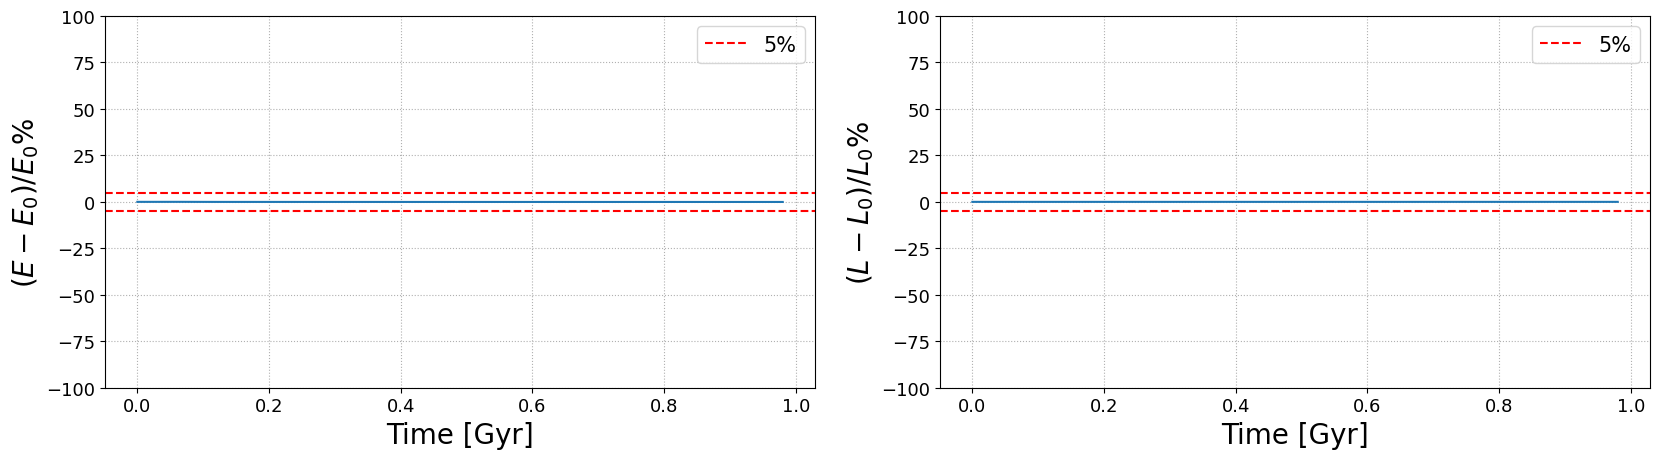

In [12]:
snapshots = jax.block_until_ready(time_integration(initial_state, mass, config, params))

energy_angular_momentum_plot(snapshots, code_units,)

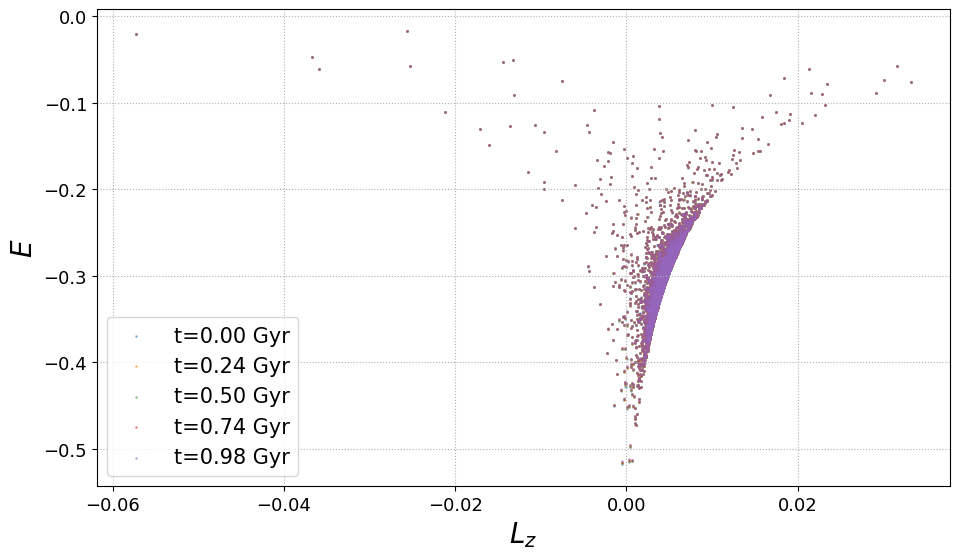

In [13]:
from odisseo.utils import E_tot, Angular_momentum

fig = plt.figure(figsize=(10, 6), tight_layout=True)
ax = fig.add_subplot(111)
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    state = snapshots.states[i]
    particles_energy = E_tot(state=state, mass=mass, config=config, params=params)
    particles_angular_momentum = Angular_momentum(state=state, mass=mass)
    ax.scatter(particles_angular_momentum[:, 2], particles_energy, s=1, alpha=0.4,label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
    ax.set_xlabel("$L_z$")
    ax.set_ylabel("$E$")
    
    # ax.set_xlim(0.04, 0.08)
    # ax.set_ylim(-0.06, 0.0)
    ax.legend()
    ax.grid(linestyle='dotted')
    

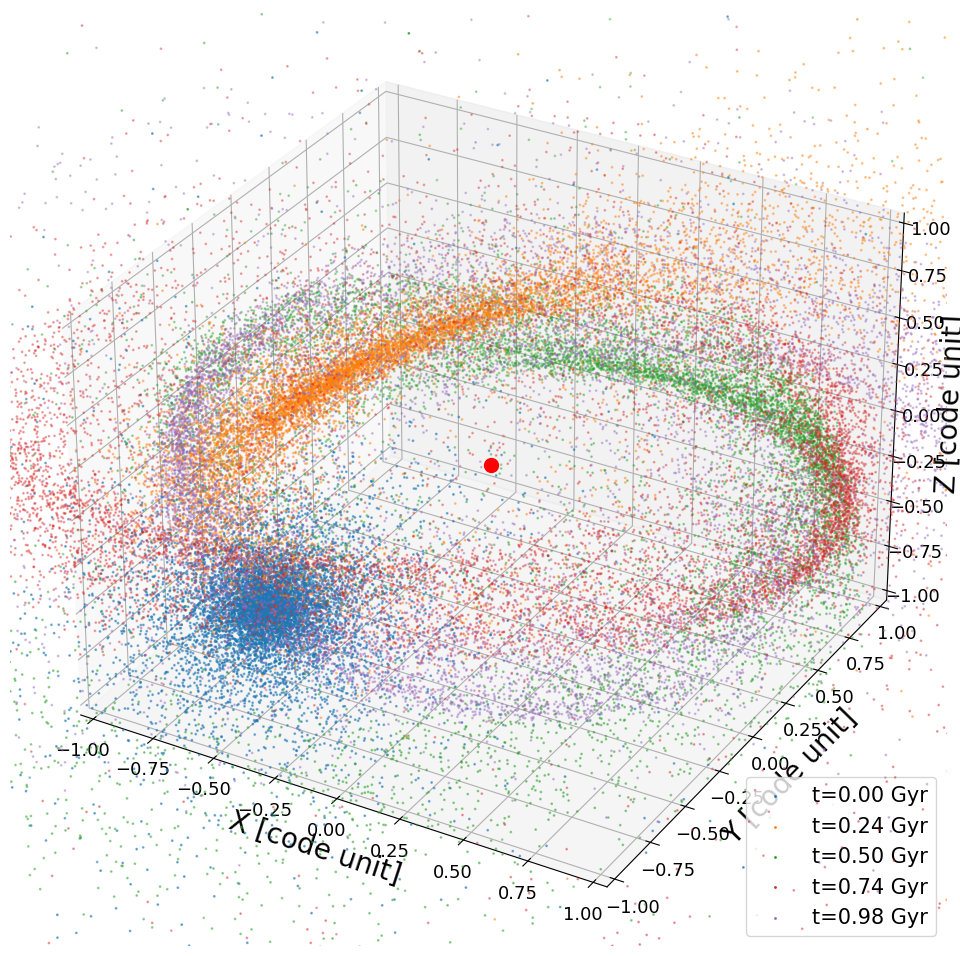

In [14]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0], snapshots.states[i, :, 0, 1], snapshots.states[i, :, 0, 2], s=1,label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='red', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
ax.set_xlim(-rp, rp)
ax.set_ylim(-rp, rp)
ax.set_zlim(-rp, rp)
ax.legend()